This experiment looks at sequences with bigger vocabularies 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
sys.path.append(os.getcwd())
from RNN_util import *
from collections import Counter 

In [4]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # update hidden 
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) # nn.Linear(input_size + hidden_size, hidden_size)
        output = self.i2o(combined) # nn.Linear(input_size + hidden_size, output_size)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# Model parameters
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)
char_to_int = {char: i for i, char in enumerate('ABCDE')}
int_to_char = {i: char for i, char in enumerate('ABCDE')}
rnn = RNN(input_size, hidden_size, output_size) 

# Check the Gradient of nested compositionality structure, and check the internal state of NN from learning sequences with such gradients 

In [12]:
def generate_sequence_with_hierarchy(n_h = 20): 
    '''n_h: every hierarchy is a new iteration of random combination '''
    # generate vocabulatory up to the nth hierarchical level
    vocab = ['A','B','C','D'] # initialize a seed vocab 
    for h in range(n_h):
        newword = ''.join([np.random.choice(vocab),np.random.choice(vocab)]) # every iteration is a combination of existing vocab 
        vocab.append(newword)
    vocab = vocab + ['E'] # E denotes an empty symbol

    alpha = np.ones(len(vocab)-1) # Concentration parameters (all set to 1 for a flat Dirichlet distribution)
    probabilities = sorted(np.random.dirichlet(alpha))# Sample a probability vector from the Dirichlet distribution, sort from low to high
    probabilities = [0.2*p for p in probabilities] + [0.8]

    l = 100000# length of the sequence 
    sequence = ''.join(np.random.choice(vocab, size=l, replace=True, p=probabilities))
    return sequence[:l], vocab


In [13]:
def get_gtseql(educated_hidden_seq,vocabulary):
    gtseql = 0
    i = 0
    while i <len(educated_hidden_seq):
        maxmatch = 0
        maxword = None
        for word in vocabulary:
            if ''.join(educated_hidden_seq[i:i+len(word)]) == word and len(word)>=maxmatch:
                    maxword = word
        i = i + len(maxword)
        gtseql = gtseql + 1
    return gtseql

In [ ]:
n_hierarchy = np.arange(0, 40, 5)  # 10 different hierarchy levels
n_iter = 10  # 10 iterations for each hierarchy level
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)
chunk_len = 5000
n_it = 300 # training iteration

gtseql_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}# ground truth sequence length
data_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
vocab_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
initial_vocab_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
parsed_vocab_size_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
filtered_vocab_size_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
# Example: Store data at each hierarchy level and iteration
for level in n_hierarchy:
    for i in range(n_iter):
        print('level is ', level)
        # Example data: store a random value (replace this with your actual data)
        sequence, vocabulary = generate_sequence_with_hierarchy(n_h = level)
        educated_rnn = RNN(input_size, hidden_size, output_size) 
        educated_NN, educated_hidden_states, educated_hidden_seq,_,_,_ = train_rnn(educated_rnn, sequence,input_size,char_to_int, int_to_char, n_iters = n_it, chunk_len = chunk_len, learn = True)
        # educated_NN, educated_hidden_states, educated_hidden_seq  = train_rnn(educated_rnn, sequence, n_iters = n_it, chunk_len = chunk_len, learn = True)
        gtseql = get_gtseql(educated_hidden_seq, vocabulary)# ground truth sequence parsing length 
        educated_hidden_states = np.array(educated_hidden_states)
        educated_hidden_unit_activity = educated_hidden_states[:, 0, :].T
        educated_cluster_center_record, educated_symbolic_hidden_activity = learn_neural_clusters(educated_hidden_unit_activity, n_neurons = hidden_size,num_bins = 3)
        educated_symbolic_hidden_activity = np.array(educated_symbolic_hidden_activity) # each label in each neuron is independent
        educated_trajcopy, educated_input_parse, vocab, educated_initial_vocab_size = learn_chunks(educated_symbolic_hidden_activity,educated_hidden_seq)
        
        gtseql_dict[str(level)][f'iteration_{i}'] = gtseql
        data_dict[str(level)][f'iteration_{i}'] = len(educated_trajcopy)
        vocab_dict[str(level)][f'iteration_{i}'] = len(vocab)
        initial_vocab_dict[str(level)][f'iteration_{i}'] = len(educated_initial_vocab_size)
        parsed_vocab_size_dict[str(level)][f'iteration_{i}'] = len(Counter(educated_trajcopy))
        filtered_vocab = {key: value for key, value in vocab.items() if value > 5}
        filtered_vocab_size_dict[str(level)][f'iteration_{i}'] = len(filtered_vocab)
        

level is  0
Iteration 100 loss: 0.720737744140625 acc: 0.8004
Iteration 200 loss: 0.708846484375 acc: 0.8058
Iteration 300 loss: 0.73149853515625 acc: 0.796
level is  0
Iteration 100 loss: 0.737942724609375 acc: 0.8006
Iteration 200 loss: 0.74105908203125 acc: 0.8012
Iteration 300 loss: 0.74437978515625 acc: 0.798
level is  0
Iteration 100 loss: 0.697355322265625 acc: 0.7986
Iteration 200 loss: 0.69388876953125 acc: 0.7972
Iteration 300 loss: 0.68707294921875 acc: 0.803
level is  0
Iteration 100 loss: 0.74340927734375 acc: 0.8066
Iteration 200 loss: 0.7594369140625 acc: 0.7996
Iteration 300 loss: 0.754131884765625 acc: 0.8008
level is  0
Iteration 100 loss: 0.76815537109375 acc: 0.797
Iteration 200 loss: 0.7841962890625 acc: 0.7908
Iteration 300 loss: 0.75275302734375 acc: 0.8026
level is  0
Iteration 100 loss: 0.7559189453125 acc: 0.7892
Iteration 200 loss: 0.720681884765625 acc: 0.8038
Iteration 300 loss: 0.700000390625 acc: 0.811
level is  0
Iteration 100 loss: 0.71262255859375 acc:

In [ ]:
import json
with open('hierarchy_gradient_n_chunk.json', 'w') as json_file:
    json.dump(data_dict, json_file)
with open('hierarchy_gradient_n_chunk_vocab.json', 'w') as json_file:
    json.dump(vocab_dict, json_file)
with open('hierarchy_gradient_n_initial_vocab.json', 'w') as json_file:
    json.dump(initial_vocab_dict, json_file)
with open('parsed_vocab_size_dict.json', 'w') as json_file:
    json.dump(parsed_vocab_size_dict, json_file)
with open('filtered_vocab_size_dict.json', 'w') as json_file:
    json.dump(filtered_vocab_size_dict, json_file)
with open('gtseql_dict.json', 'w') as json_file:
    json.dump(gtseql_dict, json_file)

No handles with labels found to put in legend.


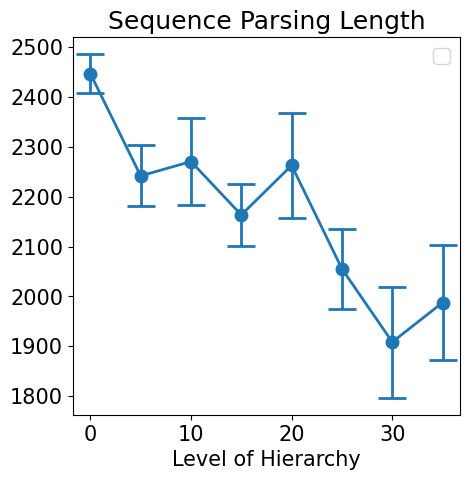

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})


# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_chunk.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(5, 5), dpi= 100)

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values, 
             fmt='-o',
             capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)

with open('gtseql_dict.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))


# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('')
plt.title('Sequence Parsing Length')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()


No handles with labels found to put in legend.


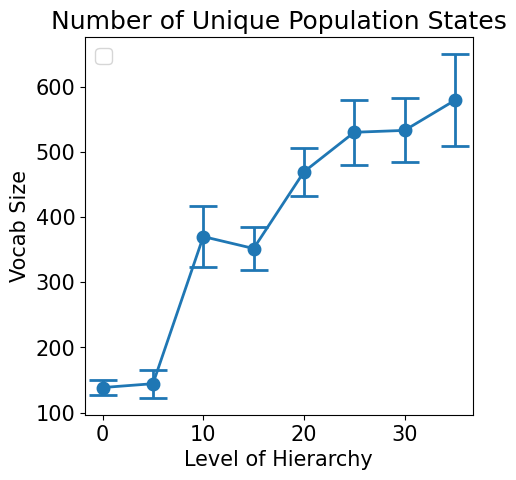

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_chunk_vocab.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(5, 5), dpi = 100)

# Loop over each hierarchy level
for level, iterations in loaded_data.items():
    # Extract iteration numbers and corresponding data points
    hiearchies.append(int(level))

    # Calculate the mean and standard deviation
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values,
fmt='-o',capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)
             
# Add shaded area representing the standard deviation
# plt.fill_between(list(iterations.keys), mean_values - std_dev_values, mean_values + std_dev_values, alpha=0.2)

# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Number of Unique Population States')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()


In [ ]:
for level, iterations in loaded_data.items():
    print(level, iterations)

No handles with labels found to put in legend.


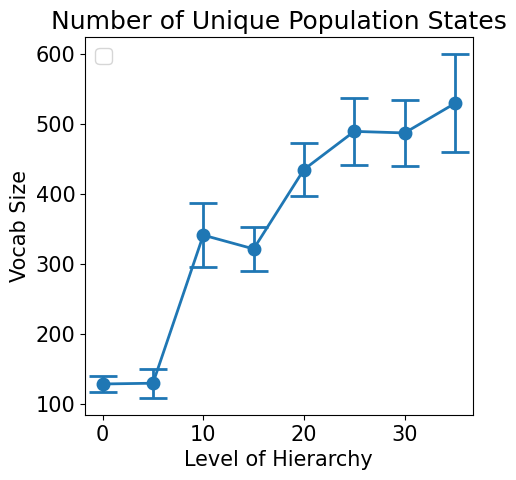

In [21]:
# vocab_dict
from scipy import stats
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_initial_vocab.json', 'r') as json_file:
    loaded_data = json.load(json_file)

loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

plt.figure(figsize=(5, 5), dpi = 100)

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

plt.errorbar(hiearchies, mean_values, yerr=sem_values,
fmt='-o',capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Number of Unique Population States')
plt.legend()
plt.grid(False)
plt.show()

No handles with labels found to put in legend.


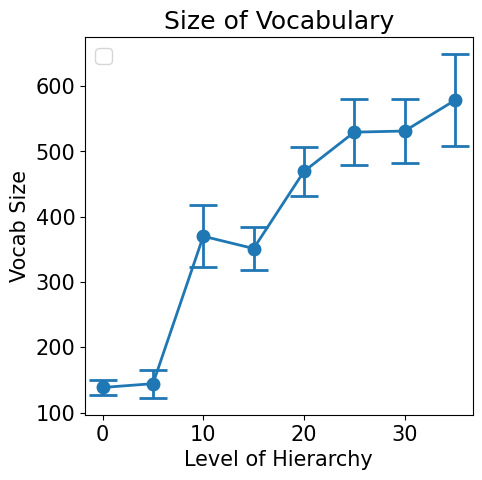

In [22]:
# Load the dictionary from the JSON file
with open('parsed_vocab_size_dict.json', 'r') as json_file:
    loaded_data = json.load(json_file)

loaded_data = {int(k): v for k, v in loaded_data.items()}
mean_values = []
sem_values = []
hiearchies = []

plt.figure(figsize=(5, 5), dpi = 100)
for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

plt.errorbar(hiearchies, mean_values, yerr=sem_values,fmt='-o',capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)
             
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Size of Vocabulary')
plt.legend()
plt.grid(False)
plt.show()